# E-19. 난 스케치를 할 테니 너는 채색을 하거라

project: Segmentation map으로 도로 이미지 만들기  

## 1. 데이터 준비하기

- 데이터 불러오기

- `augmentation` 적용
    - `padding`: 50% 확률로 Refection padding 또는 constant padding 적용(pad)
    - `crop`:  (256,256,6) 크기를 가진 이미지를 임의로 잘라내기 (random_crop)
    - `flip`: 50% 확률로 가로, 세로로 뒤집기 (flip_left_right, flip_up_down)
    - `rotation`: 50% 확률로 회전 (rot90)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


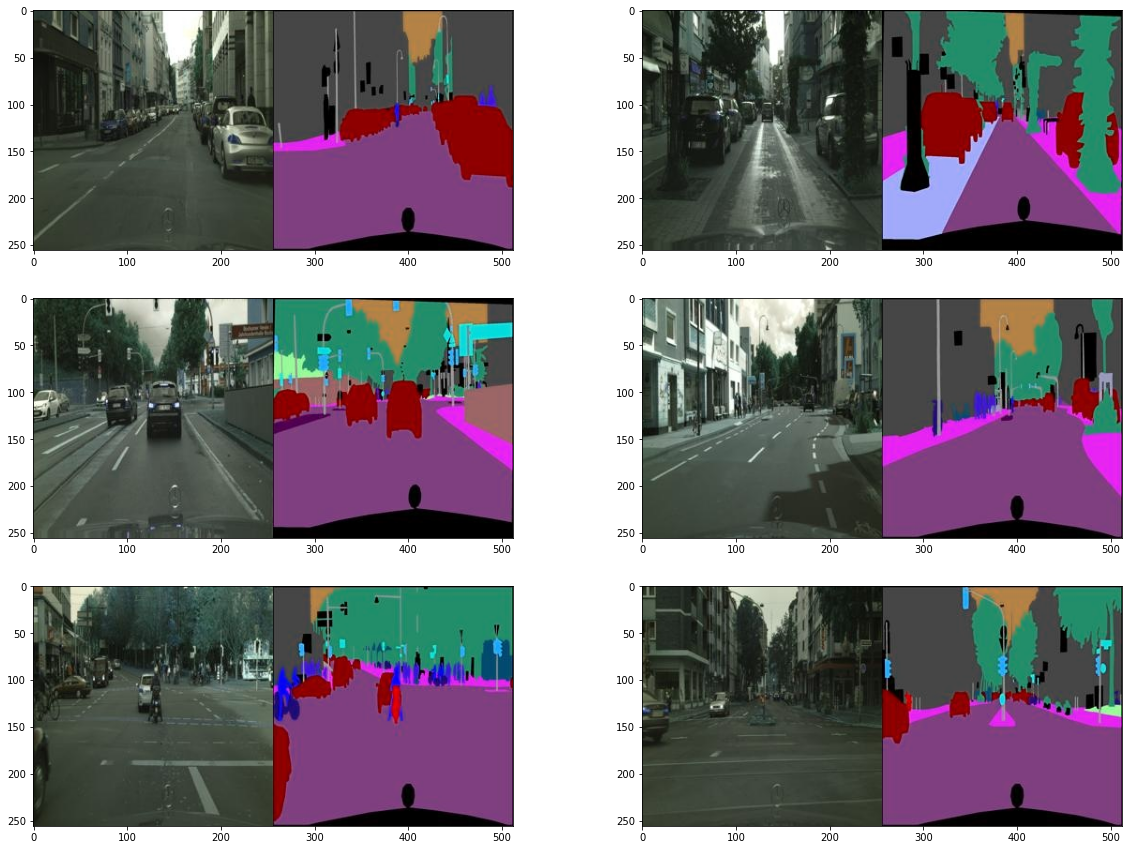

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 하나를 열어 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


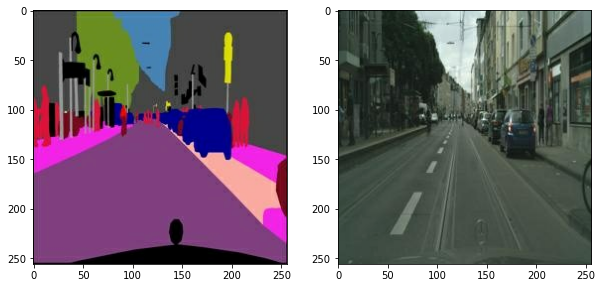

In [49]:
#(256, 256, 3) 크기의 2개 이미지로 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

In [50]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

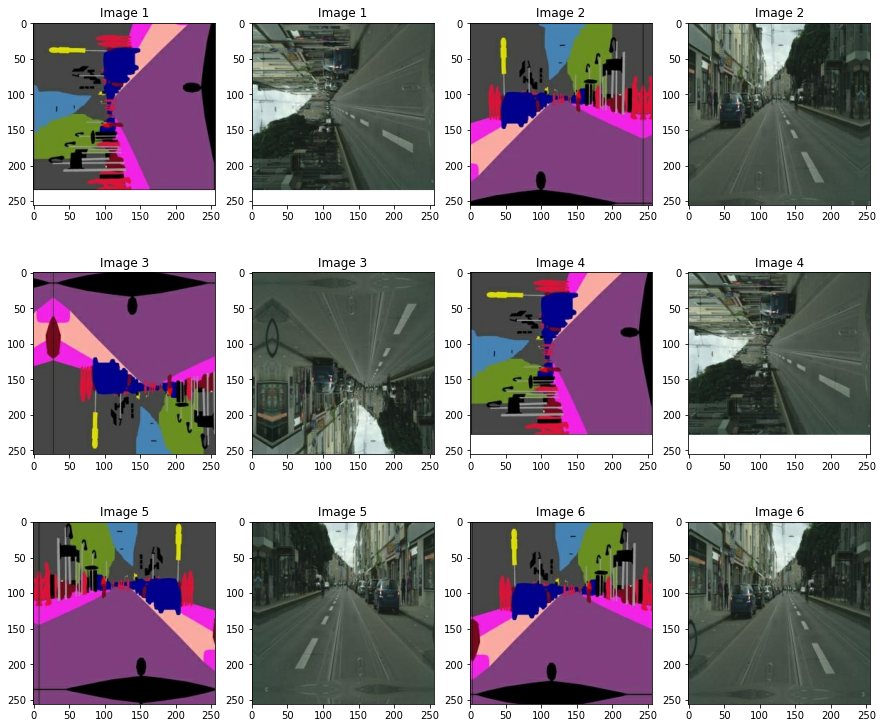

In [52]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

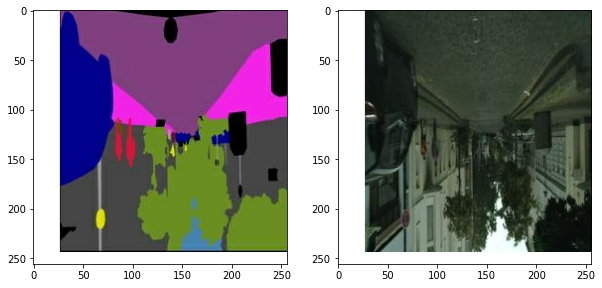

In [53]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

----
## 2.  U-Net Generator
 `Encoder`와 `Decoder`간에 `skip connection`이 있는 `U-Net Generator` 사용

In [54]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    

In [55]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [56]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

----
## 3. Discriminator

In [57]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [58]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [59]:
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_126 (Concatenate)   (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_126[0][0]      

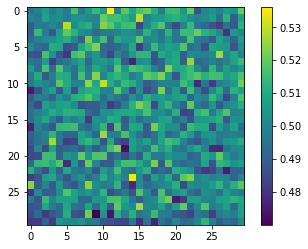

In [60]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

---
## 4. Train, Test

- Train
    - 1차: 코드를 제대로 작성했는지 확인하기 위해 1 epochs로 첫 시도
    - 2차: 100 epochs로 학습 진행
    - 3차: 500 eppochs로 학습 진행 (하던 중 컴퓨터가 꺼졌다!)

- Test
    - `generator loss`, `L1 loss`, `Discriminator loss` 시각화 
    - 테스트 결과 시각화 (스케치, 생성된 사진, 실제 사진)

In [61]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [62]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [63]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [64]:
EPOCHS = 1

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:1.9868                     
L1_loss:0.1885                     
Discriminator_loss:1.2070



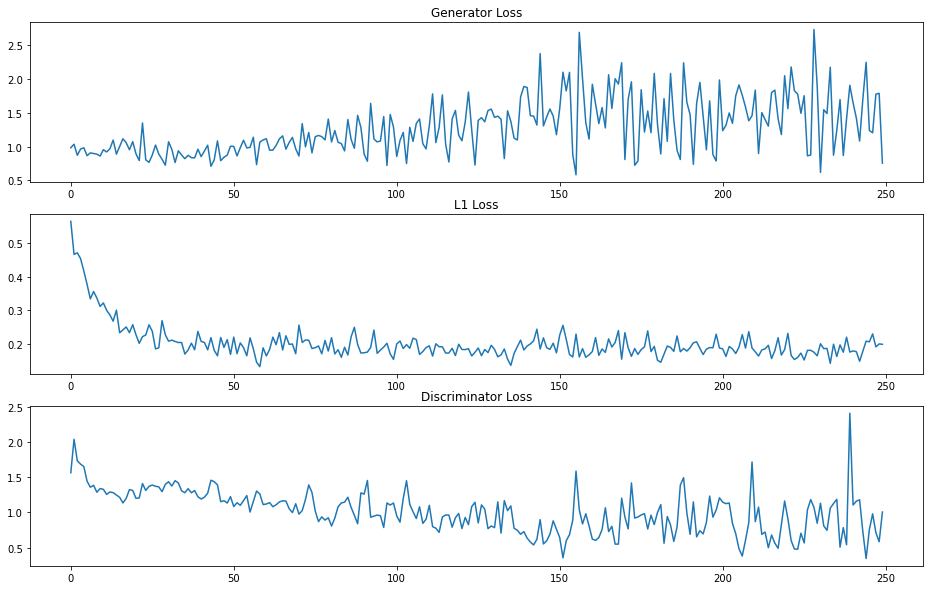

In [65]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

In [66]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of train examples :", len(os.listdir(test_path)))

number of train examples : 5


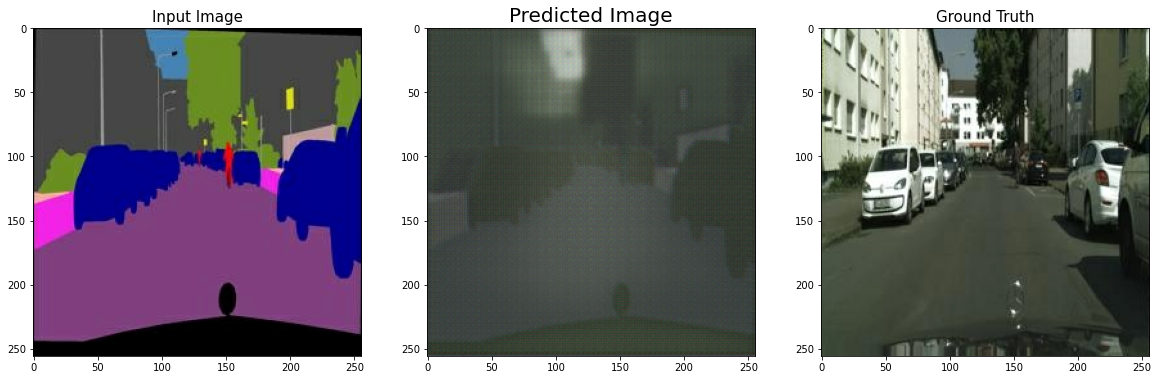

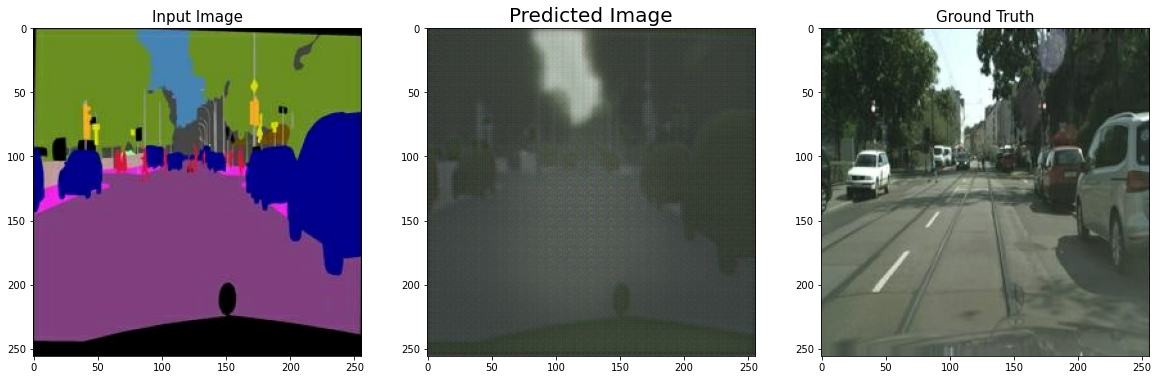

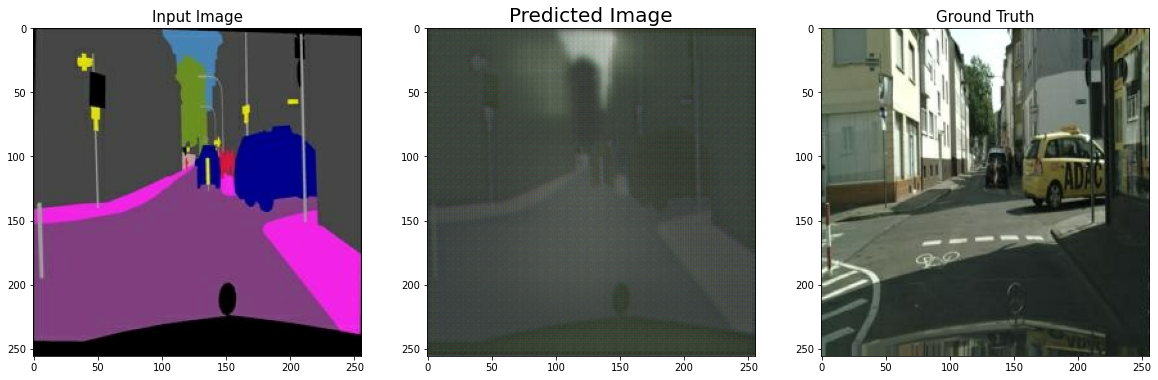

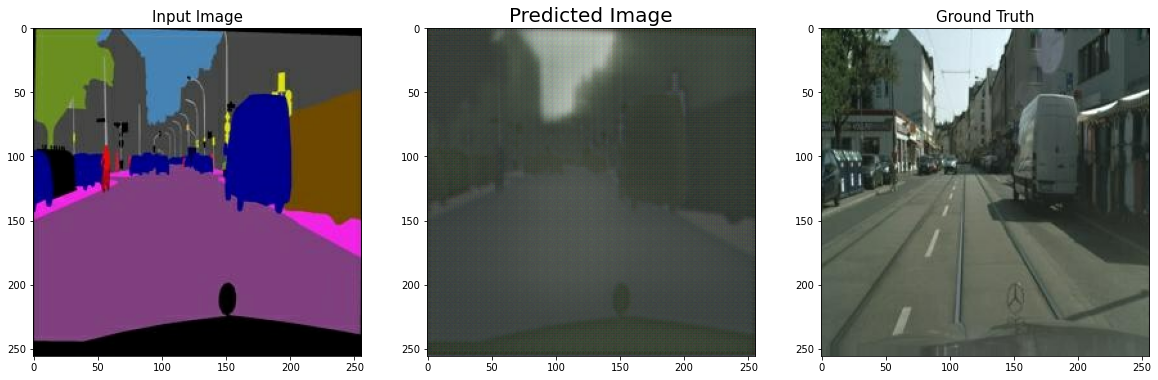

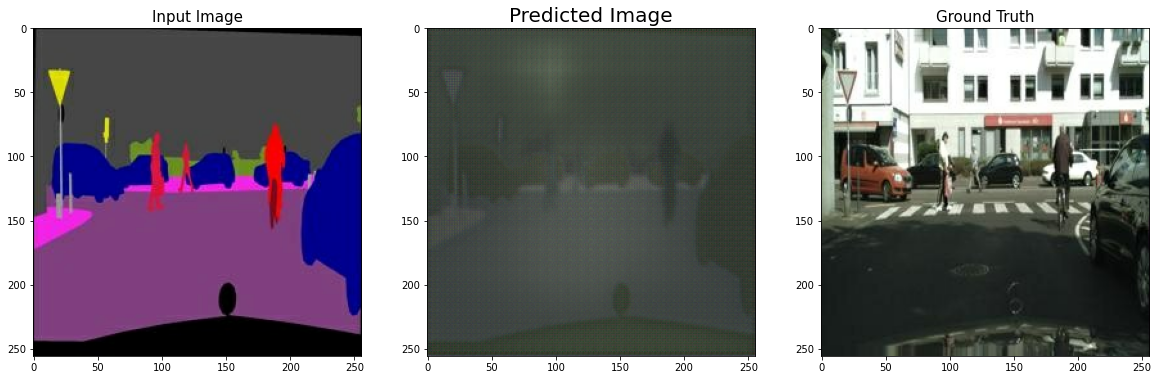

In [67]:
#도로 이미지 만들기
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)

In [68]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [69]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 200회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.8563                     
L1_loss:0.1747                     
Discriminator_loss:1.2308

EPOCH[1] - STEP[200]                     
Generator_loss:1.3456                     
L1_loss:0.1631                     
Discriminator_loss:1.4633

EPOCH[2] - STEP[100]                     
Generator_loss:2.0194                     
L1_loss:0.1842                     
Discriminator_loss:0.4967

EPOCH[2] - STEP[200]                     
Generator_loss:1.3794                     
L1_loss:0.1803                     
Discriminator_loss:1.8074

EPOCH[3] - STEP[100]                     
Generator_loss:2.4207                     
L1_loss:0.1873                     
Discriminator_loss:0.6472

EPOCH[3] - STEP[200]                     
Generator_loss:2.0308                     
L1_loss:0.1712                     
Discriminator_loss:2.8908

EPOCH[4] - STEP[100]                     
Generator_loss:1.7021                     
L1_loss:0.1780             

EPOCH[29] - STEP[100]                     
Generator_loss:0.7543                     
L1_loss:0.1793                     
Discriminator_loss:1.5481

EPOCH[29] - STEP[200]                     
Generator_loss:1.9694                     
L1_loss:0.1919                     
Discriminator_loss:0.2332

EPOCH[30] - STEP[100]                     
Generator_loss:0.8383                     
L1_loss:0.1601                     
Discriminator_loss:1.5193

EPOCH[30] - STEP[200]                     
Generator_loss:2.5496                     
L1_loss:0.1898                     
Discriminator_loss:1.3857

EPOCH[31] - STEP[100]                     
Generator_loss:1.5763                     
L1_loss:0.1506                     
Discriminator_loss:1.1458

EPOCH[31] - STEP[200]                     
Generator_loss:1.4926                     
L1_loss:0.1591                     
Discriminator_loss:1.7202

EPOCH[32] - STEP[100]                     
Generator_loss:1.2782                     
L1_loss:0.1748      

EPOCH[58] - STEP[200]                     
Generator_loss:1.3596                     
L1_loss:0.1483                     
Discriminator_loss:2.1673

EPOCH[59] - STEP[100]                     
Generator_loss:0.7263                     
L1_loss:0.1811                     
Discriminator_loss:1.1587

EPOCH[59] - STEP[200]                     
Generator_loss:1.3761                     
L1_loss:0.1168                     
Discriminator_loss:0.9350

EPOCH[60] - STEP[100]                     
Generator_loss:0.7852                     
L1_loss:0.1714                     
Discriminator_loss:0.7295

EPOCH[60] - STEP[200]                     
Generator_loss:1.6011                     
L1_loss:0.1827                     
Discriminator_loss:0.3488

EPOCH[61] - STEP[100]                     
Generator_loss:1.7559                     
L1_loss:0.1853                     
Discriminator_loss:1.7857

EPOCH[61] - STEP[200]                     
Generator_loss:1.9502                     
L1_loss:0.1697      

EPOCH[86] - STEP[100]                     
Generator_loss:1.3891                     
L1_loss:0.1700                     
Discriminator_loss:0.3966

EPOCH[86] - STEP[200]                     
Generator_loss:1.6036                     
L1_loss:0.1841                     
Discriminator_loss:0.2933

EPOCH[87] - STEP[100]                     
Generator_loss:0.8738                     
L1_loss:0.1752                     
Discriminator_loss:1.1455

EPOCH[87] - STEP[200]                     
Generator_loss:1.3029                     
L1_loss:0.1781                     
Discriminator_loss:0.9875

EPOCH[88] - STEP[100]                     
Generator_loss:1.0974                     
L1_loss:0.1648                     
Discriminator_loss:1.3345

EPOCH[88] - STEP[200]                     
Generator_loss:1.5167                     
L1_loss:0.1728                     
Discriminator_loss:0.4251

EPOCH[89] - STEP[100]                     
Generator_loss:0.8621                     
L1_loss:0.2095      

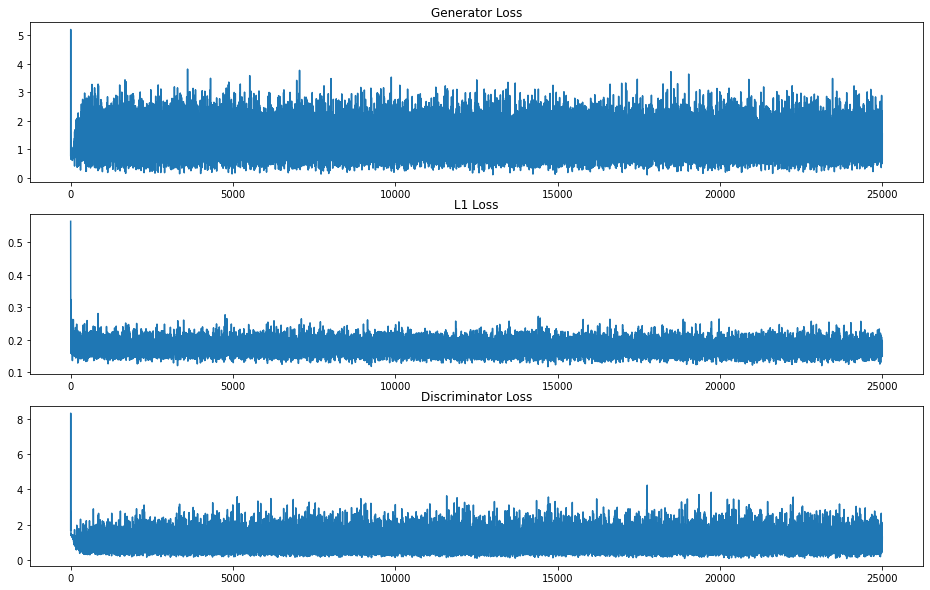

In [70]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

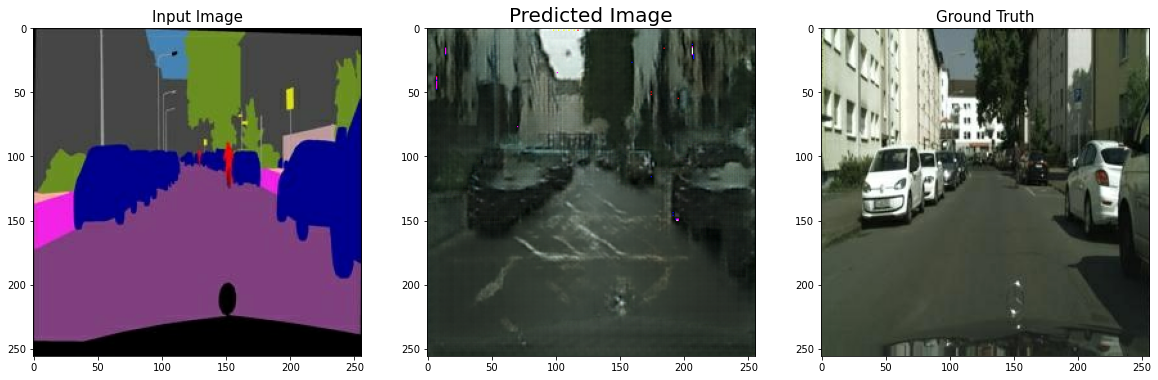

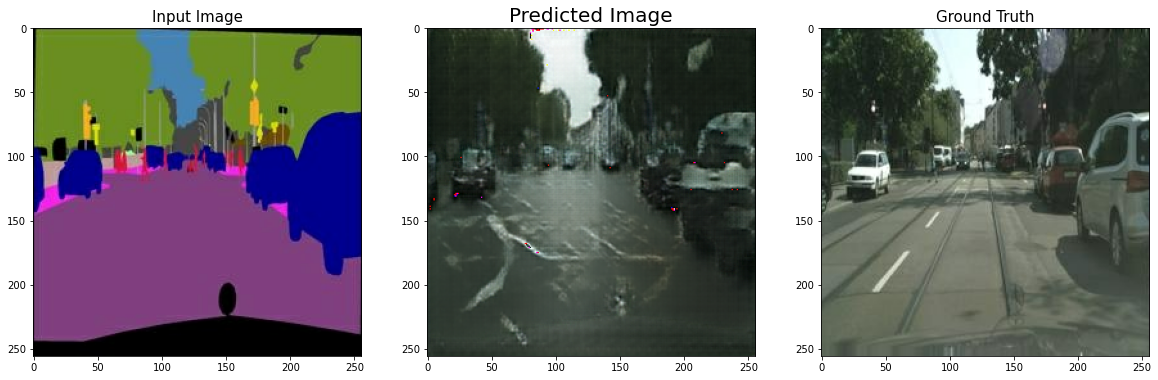

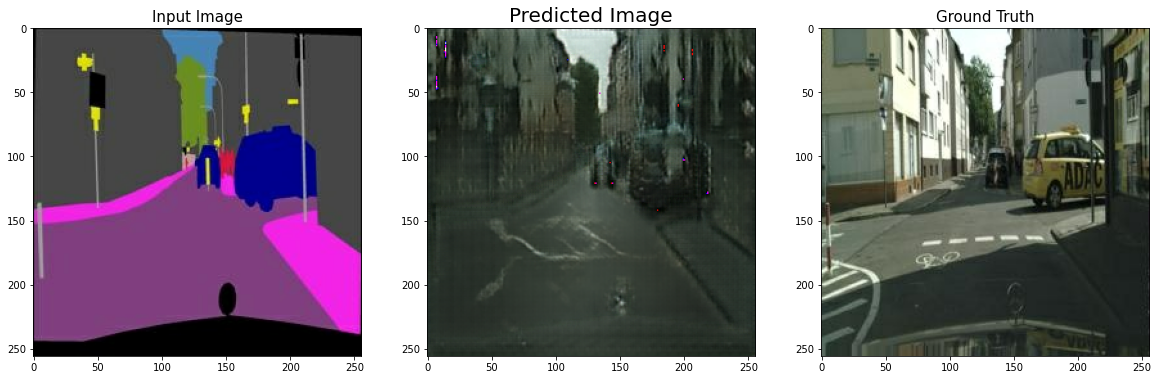

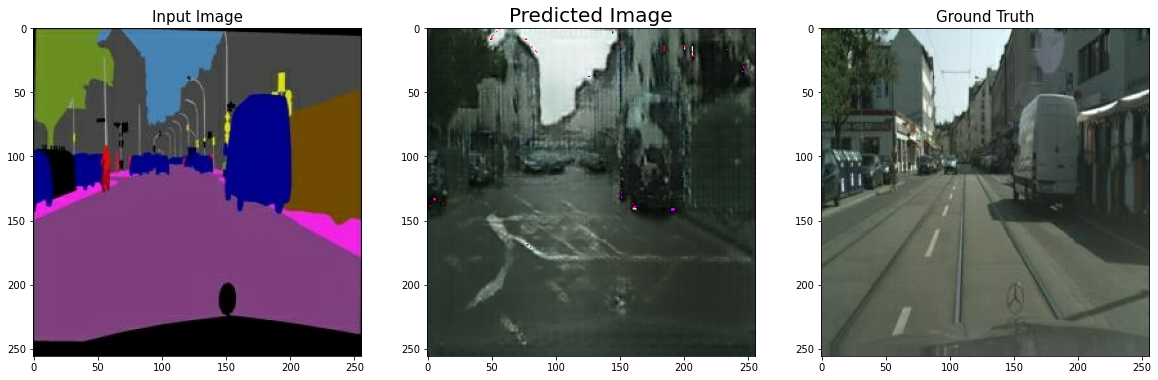

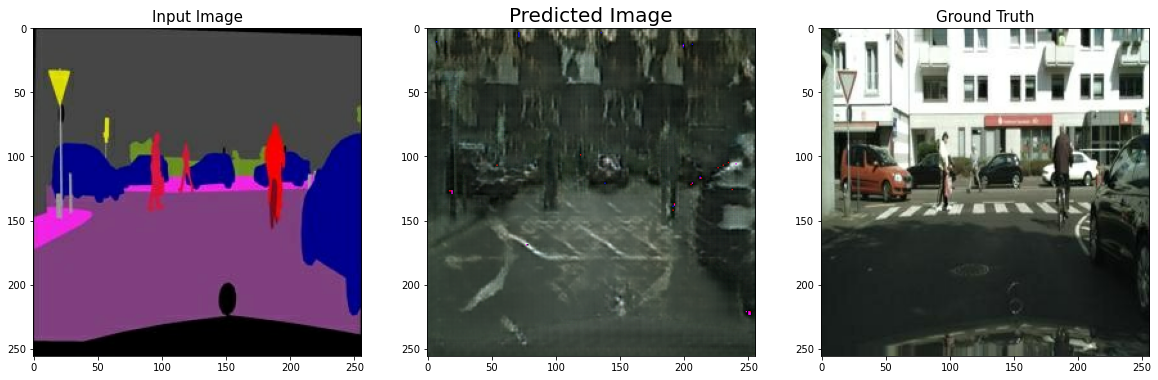

In [71]:
#도로 이미지 만들기
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)

In [73]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 500

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 200회 반복마다 손실을 출력합니다.
        if (i+1) % 250 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[250]                     
Generator_loss:1.2181                     
L1_loss:0.1621                     
Discriminator_loss:1.2187

EPOCH[2] - STEP[250]                     
Generator_loss:0.8949                     
L1_loss:0.1868                     
Discriminator_loss:0.8011

EPOCH[3] - STEP[250]                     
Generator_loss:1.5360                     
L1_loss:0.1485                     
Discriminator_loss:1.3162

EPOCH[4] - STEP[250]                     
Generator_loss:1.7308                     
L1_loss:0.2002                     
Discriminator_loss:0.4944

EPOCH[5] - STEP[250]                     
Generator_loss:1.9222                     
L1_loss:0.2149                     
Discriminator_loss:0.5784

EPOCH[6] - STEP[250]                     
Generator_loss:1.8227                     
L1_loss:0.2085                     
Discriminator_loss:0.3065

EPOCH[7] - STEP[250]                     
Generator_loss:2.3784                     
L1_loss:0.1629             

EPOCH[57] - STEP[250]                     
Generator_loss:2.2567                     
L1_loss:0.1398                     
Discriminator_loss:2.2338

EPOCH[58] - STEP[250]                     
Generator_loss:1.2935                     
L1_loss:0.1696                     
Discriminator_loss:0.6125

EPOCH[59] - STEP[250]                     
Generator_loss:1.3244                     
L1_loss:0.1728                     
Discriminator_loss:1.8248

EPOCH[60] - STEP[250]                     
Generator_loss:2.5198                     
L1_loss:0.1826                     
Discriminator_loss:0.3399

EPOCH[61] - STEP[250]                     
Generator_loss:1.0576                     
L1_loss:0.1759                     
Discriminator_loss:0.7525

EPOCH[62] - STEP[250]                     
Generator_loss:1.0406                     
L1_loss:0.1769                     
Discriminator_loss:0.6932

EPOCH[63] - STEP[250]                     
Generator_loss:1.3480                     
L1_loss:0.1844      

EPOCH[113] - STEP[250]                     
Generator_loss:2.0501                     
L1_loss:0.1483                     
Discriminator_loss:1.3921

EPOCH[114] - STEP[250]                     
Generator_loss:2.3855                     
L1_loss:0.1577                     
Discriminator_loss:1.1742

EPOCH[115] - STEP[250]                     
Generator_loss:1.0761                     
L1_loss:0.1813                     
Discriminator_loss:0.9257

EPOCH[116] - STEP[250]                     
Generator_loss:1.7368                     
L1_loss:0.1550                     
Discriminator_loss:2.3371

EPOCH[117] - STEP[250]                     
Generator_loss:1.8110                     
L1_loss:0.1710                     
Discriminator_loss:0.5313

EPOCH[118] - STEP[250]                     
Generator_loss:0.5517                     
L1_loss:0.1797                     
Discriminator_loss:2.3805

EPOCH[119] - STEP[250]                     
Generator_loss:1.3991                     
L1_loss:0.155

---
## 평가 및 회고



### 루브릭
|평가문항|상세기준|
|:--|:--|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

### 회고

최초에 테스트를 위해 epoch 1로 학습을 진행하였다.  
역시 결과는 좋지 않았으며 흐릿한 형상을 띄었다.  

두번째 시도로 epoch 100으로 시도하였으며, 이전 결과보다 상대적으로 선명해진 것을 볼 수 있다.  
하지만 여전히 결과물이 좋다라고 말할 수는 없을 것 같다.  

세번째 시도로 epoch 500으로 시도하였으나, 아쉽게도 epoch 147 중에 컴퓨터가 꺼져버렸다.  
시간적인 여유가 없어서 프로젝트 제출 후에 다시 시도하던지 해야할 것 같다.   

epoch 500 을 시도하진 못했으나, 앞선 비교를 보면 결과물이 더 좋을 것으로 생각된다.  

---
## 참고 자료

[Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)